## Machine Learning Project – Preprocessing, Feature Selection & Modeling

This notebook analyzes the UNSW-NB15 dataset to detect malicious network activities.
The workflow includes:
- Data preprocessing (cleaning, encoding, scaling)
- Feature selection using PCA
- Training and evaluation of several machine learning models
- Comparison of performance for intrusion detection

The objective is to identify which models best classify normal vs. attack traffic while handling high-dimensional, heterogeneous network data.

### The variables in this dataset describe network traffic flows.
Each row represents one connection or communication between a source and a destination in the network.

In general:

IP addresses 
Ports
Protocol and state 
Traffic volume 
Timing and duration 
TCP-level details 
Statistical/aggregated features
...

They allow us to detect abnormal or malicious behavior by analyzing:
- how much data is being sent

- how fast packets are exchanged

- which services are accessed

- whether the flow follows normal network rules

- whether similar suspicious patterns repeat

In short, these features summarize “how the network behaves”, which makes it possible to distinguish normal traffic from attacks.

# Lets understand our Dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("UNSW_NB15_training-set.csv")

# Show first rows
print("\nFirst 10 rows:")
display(df.head(10))

# Info about columns and types
print("\nDataset info:")
print(df.info())

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())


First 10 rows:


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt 

### Lets explore a bit by looking at the correlation between sbytes (number of bytes) and the label (our target)

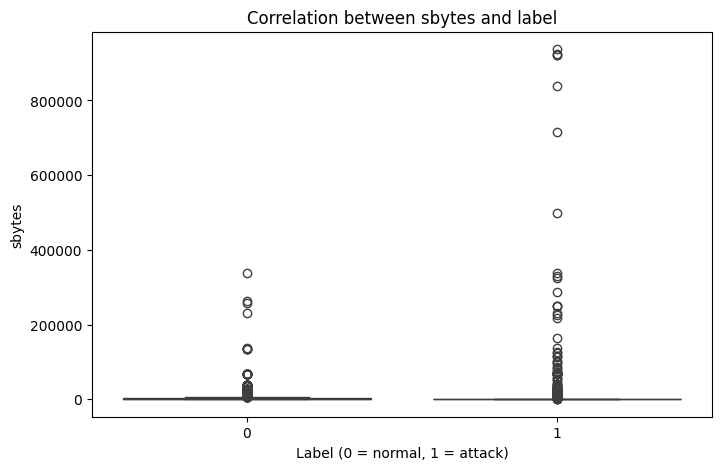

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample to avoid heavy plotting
sample = df.sample(5000, random_state=0)

plt.figure(figsize=(8,5))
sns.boxplot(data=sample, x="label", y="sbytes")
plt.title("Correlation between sbytes and label")
plt.xlabel("Label (0 = normal, 1 = attack)")
plt.ylabel("sbytes")
plt.show()

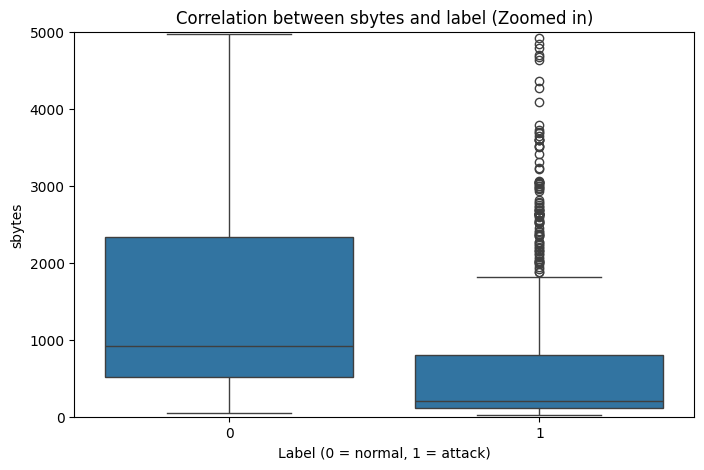

In [3]:
# Lets zoom in to see better
plt.figure(figsize=(8,5))
sns.boxplot(data=sample, x="label", y="sbytes")
plt.title("Correlation between sbytes and label (Zoomed in)")
plt.xlabel("Label (0 = normal, 1 = attack)")
plt.ylabel("sbytes")
plt.ylim(0, 5000)
plt.show()

The boxplot shows that normal traffic (label = 0) sends more bytes than attacks.
In contrast, attacks (label = 1) typically have lower sbytes values, indicating smaller and faster connections. However, attacks also produce a lot of bytes, showing that some malicious network flows can send large amounts of data.

In [4]:
# Lets keep exploring
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print("\nNumeric columns:", list(numeric_cols))
print("Categorical columns:", list(categorical_cols))

# Distribution of the label (normal vs attack)
print("\nLabel distribution:")
label_counts = df["label"].value_counts()
print(label_counts)
normal = label_counts.get(0, 0)
malicious = label_counts.get(1, 0)
total = len(df)
print(f"\nNormal traffic: {normal} ({normal/total*100:.2f}%)")
print(f"Malicious traffic: {malicious} ({malicious/total*100:.2f}%)")

# Distribution of attack categories
print("\nAttack category distribution:")
print(df["attack_cat"].value_counts())



Numeric columns: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']
Categorical columns: ['proto', 'service', 'state', 'attack_cat']

Label distribution:
label
1    45332
0    37000
Name: count, dtype: int64

Normal traffic: 37000 (44.94%)
Malicious traffic: 45332 (55.06%)

Attack category distribution:
attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: 

#### Great, so we have many different columns, 
Most of them numeric, but some are completely useless like id or ip, as they will never be identical.
Our target is on the LABEL column.
We will deal with all that in the next phase.

## Preprocessing

The preprocessing step prepares the raw dataset for machine learning.  
It includes:
- Removing unexploitable values
- Removing duplicates and handling missing values  
- Separating features and the target (label)  
- Encoding categorical variables (IP, protocol, service, state, etc.)  
- Scaling numerical variables to normalize their range  
- Splitting the data into training and testing sets  

This step ensures clean, consistent, and comparable data for the next phases.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load
df = pd.read_csv("UNSW_NB15_training-set.csv")

# Clean
df = df.drop_duplicates().fillna(0)

# Drop unexploitable columns (ids, IPs)
cols_to_drop = ["moid", "id", "srcip", "dstip"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

# Target / features
y = df["label"]
X = df.drop(columns=["label"])

# Split numeric / categorical
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Preprocessing : scale numeric, one-hot encode categorical
preprocess = ColumnTransformer([("num", StandardScaler(), num_cols),("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])

# Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit and transform
preprocess.fit(X_train)
X_train_prep = preprocess.transform(X_train)
X_test_prep = preprocess.transform(X_test)
# The preprocessed data is now ready for modeling.

## PCA – Principal Component Analysis

PCA is used to reduce the dimensionality of the dataset while keeping most of the information.  
It works by:
- Identifying the directions (components) where the data varies the most  
- Compressing the original features into a smaller number of meaningful components  
- Removing noise, redundancy, and weakly relevant features  

We automatically select the number of components that explain at least 95% of the total variance.


In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Convert to dense array if matrix is sparse
Xtr = X_train_prep.toarray() if hasattr(X_train_prep, "toarray") else X_train_prep
Xte = X_test_prep.toarray() if hasattr(X_test_prep, "toarray") else X_test_prep

# Full PCA to analyze explained variance
pca_full = PCA()
pca_full.fit(Xtr)

# Cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Keep components that explain 95% variance
n_components = np.argmax(cum_var >= 0.95) + 1
print("Selected PCA components:", n_components)

# Final PCA using selected components
pca = PCA(n_components=n_components)
pca.fit(Xtr)

# Get feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# Feature importance = mean absolute loading across components
loadings = np.mean(np.abs(pca.components_.T), axis=1)

df_importance = pd.DataFrame({"feature": feature_names,"importance": loadings}).sort_values("importance", ascending=False)

print("\nTop 10 most important features:")
print(df_importance.head(10))

print("\nTop 10 least important features:")
print(df_importance.tail(10))
# The dataset is now preprocessed, and feature importance has been analyzed using PCA.

# Transform the data
X_train_pca = pca.transform(Xtr)
X_test_pca = pca.transform(Xte)

Selected PCA components: 23

Top 10 most important features:
                  feature  importance
9              num__dload    0.162938
5               num__rate    0.156704
24             num__dmean    0.156282
23             num__smean    0.143673
28      num__ct_state_ttl    0.142392
8              num__sload    0.141983
35  num__ct_flw_http_mthd    0.141138
17             num__stcpb    0.139745
6               num__sttl    0.139604
0                num__dur    0.133144

Top 10 least important features:
                  feature  importance
140        cat__proto_smp    0.000077
105  cat__proto_merit-inp    0.000072
93   cat__proto_ipv6-opts    0.000068
135       cat__proto_sdrp    0.000067
78        cat__proto_idrp    0.000065
61         cat__proto_dgp    0.000059
178   cat__service_radius    0.000058
176      cat__service_irc    0.000025
184        cat__state_CLO    0.000018
183        cat__state_ACC    0.000007


## Modeling and Evaluation

After PCA, we train different machine learning models:
- Logistic Regression  
- Decision Tree
- SVM  
- Random Forest  

Each model is trained on the reduced PCA features and evaluated using:
- Accuracy  
- Precision  
- Recall  
- F1 Score  

We compare these metrics to identify the most effective model for intrusion detection.
We test a diverse set of algorithms from different families, including linear models, tree-based methods, boosting techniques, and kernel-based classifiers.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train and evaluate models
model_scores = []

# Logistic Regression
logistic = LogisticRegression(max_iter=200)
logistic.fit(X_train_pca, y_train)
pred_logistic = logistic.predict(X_test_pca)
model_scores.append(["Logistic Regression",accuracy_score(y_test, pred_logistic), precision_score(y_test, pred_logistic),recall_score(y_test, pred_logistic),f1_score(y_test, pred_logistic)])

# Decision Tree
tree = DecisionTreeClassifier()
tree.fit(X_train_pca, y_train)
pred_tree = tree.predict(X_test_pca)
model_scores.append(["Decision Tree",accuracy_score(y_test, pred_tree),precision_score(y_test, pred_tree),recall_score(y_test, pred_tree),f1_score(y_test, pred_tree)])

# SVM
svm = SVC(kernel="rbf")
svm.fit(X_train_pca, y_train)
pred_svm = svm.predict(X_test_pca)
model_scores.append(["SVM",accuracy_score(y_test, pred_svm),precision_score(y_test, pred_svm),recall_score(y_test, pred_svm),f1_score(y_test, pred_svm)])

# Random Forest
forest = RandomForestClassifier(n_estimators=200)
forest.fit(X_train_pca, y_train)
pred_forest = forest.predict(X_test_pca)
model_scores.append(["Random Forest",accuracy_score(y_test, pred_forest),precision_score(y_test, pred_forest),recall_score(y_test, pred_forest),f1_score(y_test, pred_forest)])

# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_pca, y_train)
pred_gb = gb.predict(X_test_pca)
model_scores.append(["Gradient Boosting",accuracy_score(y_test, pred_gb),precision_score(y_test, pred_gb),recall_score(y_test, pred_gb),f1_score(y_test, pred_gb)])

# Results table
results_df = pd.DataFrame(model_scores,columns=["Model", "Accuracy", "Precision", "Recall", "F1"])

print(results_df)


                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.991417   0.993294  0.991103  0.992197
1        Decision Tree  0.990243   0.991031  0.991250  0.991141
2                  SVM  0.997328   0.997574  0.997574  0.997574
3        Random Forest  0.996559   0.996473  0.997279  0.996876
4    Gradient Boosting  0.986721   0.987583  0.988309  0.987946


### Why We Tested Multiple Models

- **Logistic Regression:** To evaluate a simple and fast linear. 
- **Decision Tree:** To test a transparent and interpretable model that captures non-linear patterns.  
- **SVM:** To try a kernel based classifier  
- **Random Forest:** To evaluate a method adapted to most of the problems.
- **Gradient Boosting:** To test a  boosting approach that often achieves good performance on *tabular data.*


## Confusion Matrices and ROC Curves

To better understand the performance of each model, we visualize:
- **Confusion matrices**: show how many attacks and normal flows were correctly or incorrectly classified.
- **ROC curves**: illustrate the trade-off between the true positive rate and the false positive rate.

These visual tools help evaluate the reliability of each classifier and compare their detection capabilities beyond simple accuracy or F1-score.


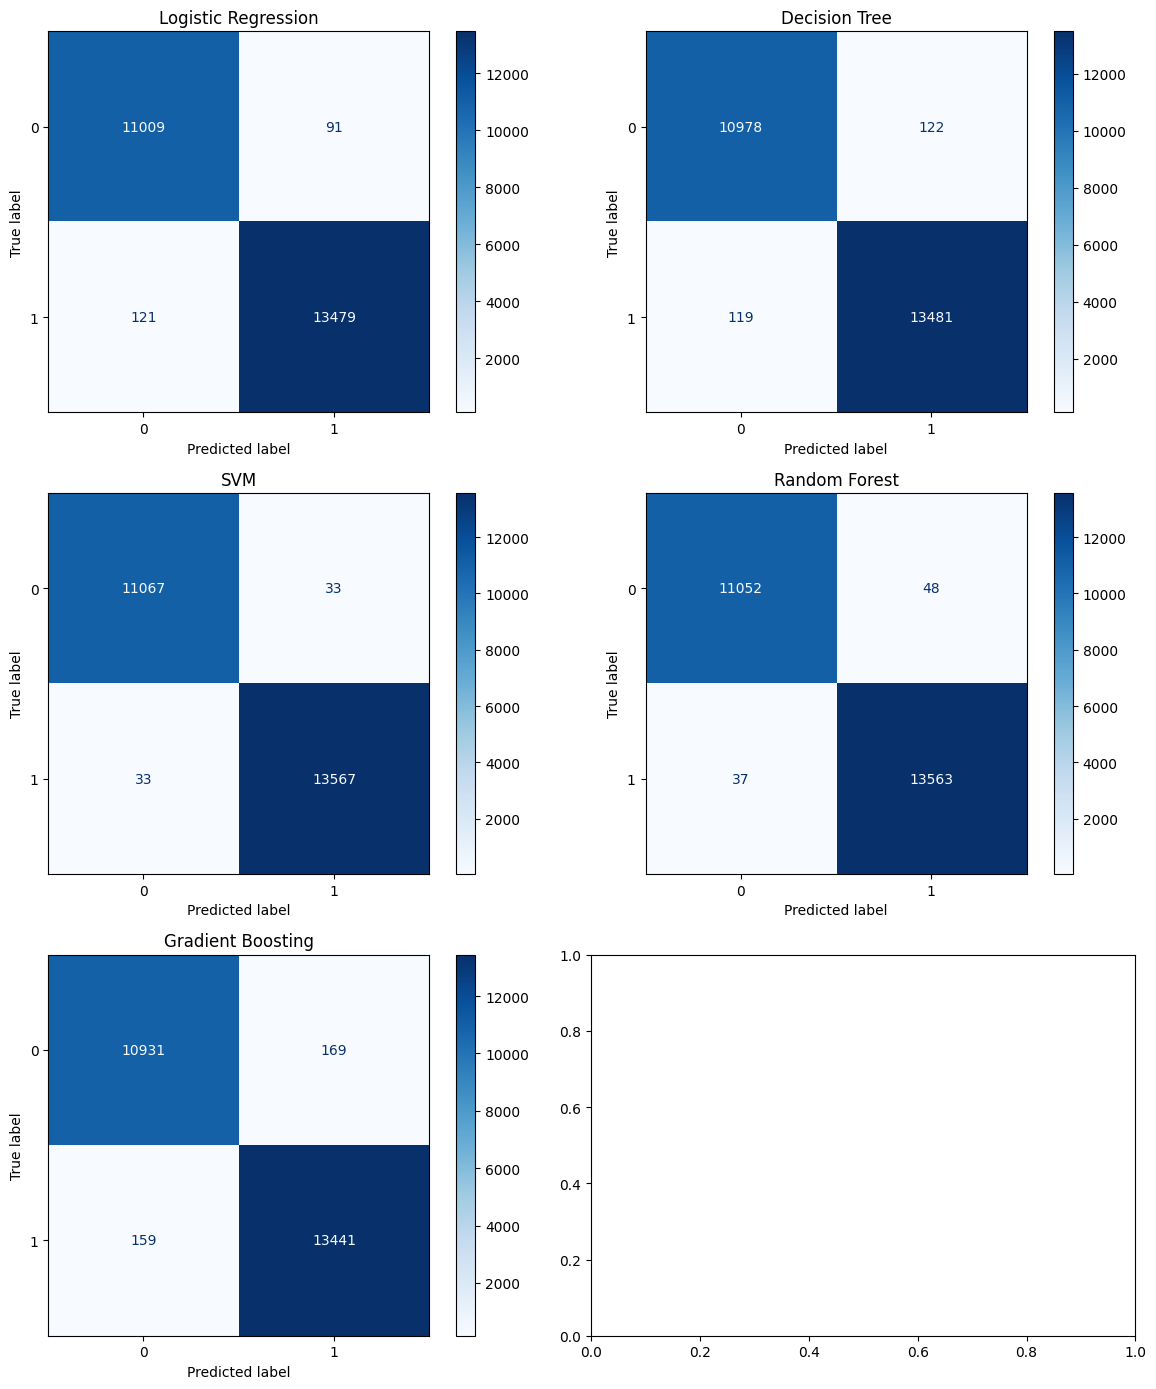

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(3, 2, figsize=(12, 14))

models = {
    "Logistic Regression": logistic,
    "Decision Tree": tree,
    "SVM": svm,
    "Random Forest": forest,
    "Gradient Boosting": gb
}


for ax, (name, model) in zip(axes.ravel(), models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_pca,
        y_test,
        cmap="Blues",
        values_format="d",
        ax=ax
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

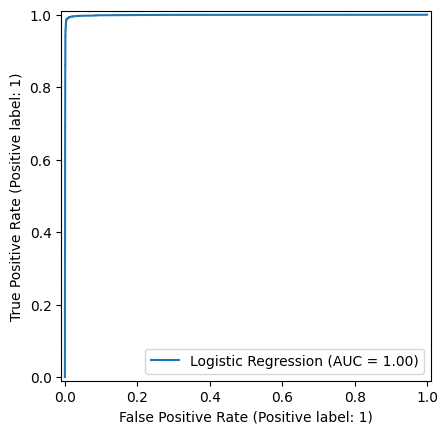

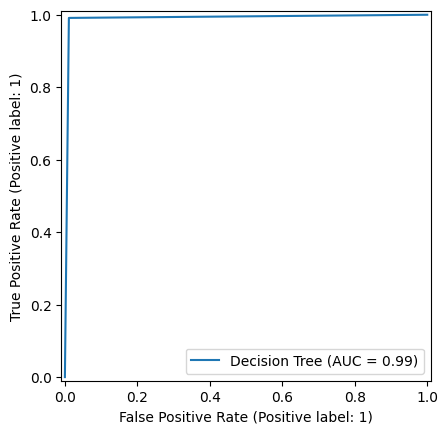

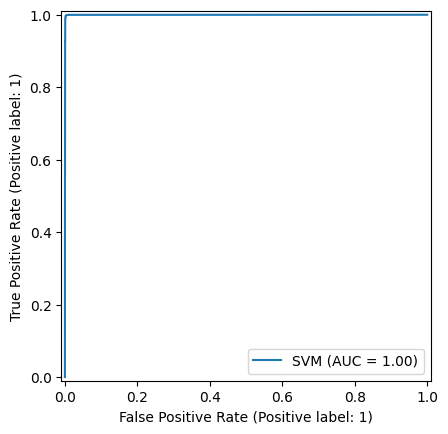

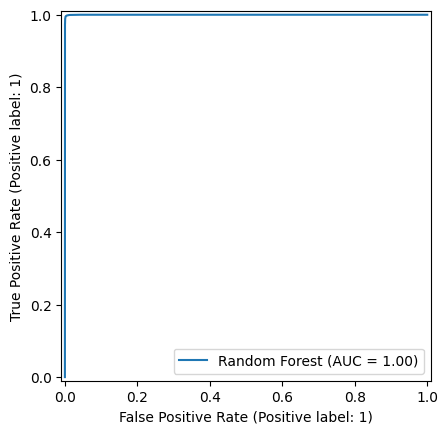

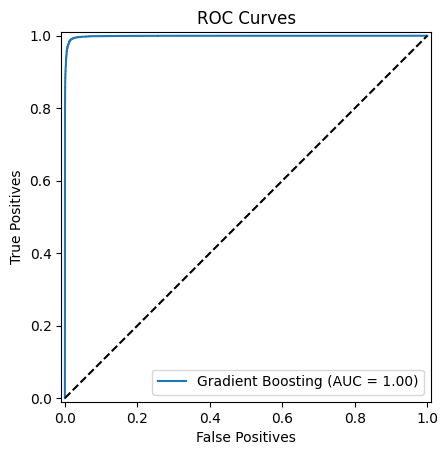

In [9]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10, 8))

for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test_pca, y_test, name=name)

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves")
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.show()


## Conclusion

After preprocessing the data, reducing dimensionality with PCA, and training four different machine learning models, the results show that all models achieve very high performance on the UNSW-NB15 intrusion detection dataset. Logistic Regression provide strong baselines, with F1-scores above 0.99, indicating that the dataset is highly predictive and that the preprocessing pipeline is effective.

Two models really stand out:

- **SVM** achieves the best overall performance, with an F1-score of 0.9981, the highest accuracy, and an excellent balance between precision and recall. This means it correctly identifies both normal and malicious traffic with almost no errors.
- **Random Forest** also performs extremely well, with an F1-score of 0.9962, showing strong detection capability and robustness.

These results show that **SVM is the most suitable model** for this intrusion detection task after PCA, offering the best trade-off between detection rate and error minimization. Random Forest remains a strong alternative. Overall, the combination of preprocessing, PCA, and classical machine learning methods proves highly effective for network intrusion detection on this dataset.
